# Титаник: класификация, data exploration, feature engineering

Днес:

* Ще разгледаме един от култовите dataset-и в Kaggle: titanic
* Ще пробваме няколко класификационни алгоритми
* Ще ровим в данните и ще измислим няколко feature-а за да подобрим модела

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline

# Преди това

Да погледнем малко pandas.

# Pandas

`pandas` е библиотека с добри инструменти за data science. Има доста възможности, но най-ключовоте неща в нея (за нашите цели) е `DataFrame` обекта. Това е таблица с данни, с която може да изпълняваме интересни операции. `DataFrame`-овете работят добре с scikit-learn – може да ги подавате директно на моделите.

In [ ]:
characters = \
  pd.DataFrame([["John Snow", "male", 16, 3, 2],
                ["Arya Stark", "female", 11, 4, 1],
                ["Daenerys Targeryan", "female", 16, 2, 1],
                ["Jamie Lannister", "male", 36, 1, 1]
               ], columns=['Name', 'Gender', 'Age', 'Brothers', 'Sisters'])
    
characters

Може да видим малко информация за този data frame:

In [ ]:
characters.info()

Обърнете внимане, че всяка колона има отделен тип.

Може да създадете `DataFrame` и с речник:

In [ ]:
characters = \
  pd.DataFrame({
    'Name': ['John Snow', 'Arya Stark', 'Daenerys Targeryan', 'Jamie Lannister'],
    'Gender': pd.Categorical(['male', 'female', 'female', 'male']),
    'Age': [16, 11, 16, 36],
    'Brothers': [3, 4, 2, 1],
    'Sisters': [2, 1, 1, 1],
  }, columns=['Name', 'Gender', 'Age', 'Brothers', 'Sisters'])

characters

Тук имаме леко различни типове:

In [ ]:
characters.info()

Има тон забавни операции. Например филтриране:

In [ ]:
characters[characters.Age < 20]

Може да видим статистика за някои от колоните:

In [ ]:
characters.describe()

Обърнете внимание, че това показва само числовите колони

Може да сортирате:

In [ ]:
characters.sort_values(by=['Age', 'Name'])

Може да направите импровизиран one-hot encoding:

In [ ]:
encoded = characters.copy()
encoded['Male'] = (encoded.Gender == 'male').astype(float)
encoded['Female'] = (encoded.Gender == 'female').astype(float)
encoded

Можете дори да си направите нова колона като функция от други колони:

In [ ]:
extended = characters.copy()
extended['Siblings'] = extended.Brothers + extended.Sisters
extended

# Titanic

Titanic е първия dataset с който ще се сблъскате в Kaggle. Може да го изтеглите от тук:

https://www.kaggle.com/c/titanic

Данните съдържат историческата информация за пътниците (възраст, пол, име, т.н.) на кораба, както и label-и дали са оцелели.

Отговаряме на класификационнен въпрос. Именно:

Кой от тези двамата ще умре?

![titanic.jpeg](https://www.movieposter.com/posters/archive/main/142/MPW-71146)

Да започнем със зареждане на dataset-а. Ползваме `pandas`.

Първо, ще ограничим колко реда се показват до 15 (за да се събират в слайдовете):

In [ ]:
pd.options.display.max_rows = 15

След това зареждаме данните:

In [ ]:
pd.read_csv('data/titanic/train.csv')

`PassengerId` изглежда като иднекс, който няма да ни даде нищо интересно. Може да отрежем колоната, но pandas има трик за целта:

In [ ]:
original = pd.read_csv('data/titanic/train.csv', index_col='PassengerId')
original

Какво ли значат тези данни? Може да видим в Kaggle:

| Variable | Definition                                 | Key                                            |
|:---------|:-------------------------------------------|:-----------------------------------------------|
| Survived | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |


Да видим малко статистика:

In [ ]:
original.describe()

Забелязва се, че не всички колони имат стойности - например Age. Нека да видим какво е положението при другите:

In [ ]:
original.isnull().sum().sort_values()

Трябва да решим този проблем. Анализът ни на трите колони е следния:

* Липсват само две `Embarked` – може да ги попълним както си искаме, няма да има голямо значение.
* Повечето `Cabin` липсват – едва ли може да извлечем интересна информация от там (ако не се постараем твърде много) и може да игнорираме колоната
* `Age` вече е проблем – трябва да изберем какво да направим.

## Обработка на Age

Опциите ни са:

1. Да разкараме редовете
2. Да попълним с нули
3. Да попълним със средната стойност на колоната
4. Да направим някаква магия

1 не е опция, понеже ще загубим около 20% от данните. Dataset-а е малък. 2 също не е най-доброто решение, понеже ще измести данните твърде много в една посока. Понеже още не сме магьосници, ще почнем с 3.

In [ ]:
data = original.copy()
data['Age'] = data.Age.fillna(data.Age.mean())
data

Да видим какво стана:

In [ ]:
data.describe()

Чудесно! Нека започнем с baseline модел.

# Baseline модел

За начало ще пробваме да baseline тренираме модел само с числовите колони. Веднъж като имаме отправна точка, ще пробваме да подобрим нещата с още feature-и:

In [ ]:
X = data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
y = data['Survived']

In [ ]:
X

In [ ]:
y

Нека погледнем колко човека са оцелели:

In [ ]:
y.value_counts().plot.pie(explode=[0, 0.1], figsize=(8, 8), autopct='%1.1f%%');

Обърнете внимане, че класовете не са 50/50.

Нека си отделим тренировъчен модел:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

Ползваме `stratify` за да се уверим, че `y_train` и `y_test` запазват пропорциите:

In [ ]:
y_train.mean()

In [ ]:
y_test.mean()

Ще се пробваме първоначално с логичстична регресия:

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Виждаме, че модела се справя учудващо добре с толкова малко данни и не overfit-ва. Все пак, има голямо поле за подобрение.

Да пробваме и с random forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Тук вече има голям overfit. Може да се опитаме да регуляризираме. По принцип няма смисъл на този етап, но нека да демонстрираме Grid Search:

In [ ]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(model, {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

Изглежда, че няма да видим много драматчина разлика.

Резултати са малко по-подробни, може да ги разгледате:

In [ ]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

Нека тренираме модел с най-добрите параметри:

In [ ]:
model = RandomForestClassifier(max_depth=6, n_estimators=100, random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Това е малко по-добре, но като цяло беше безсмислено упражнение. Да продължим напред!

Да се върнем на dataset-а.

Каква според вас е следващата стъпка?

# Data exploration

Нека погледнем какви feature-и не ползваме:

| Variable       | Definition                                   | Key                                              |
| :------------- | :------------------------------------------- | :----------------------------------------------- |
| **Survived**   | Survival                                     | 0 = No, 1 = Yes                                  |
| Name           | Name of the passenger                        |                                                  |
| **Pclass**     | Ticket class                                 | 1 = 1st, 2 = 2nd, 3 = 3rd                        |
| Sex            | Sex                                          |                                                  |
| **Age**        | Age in years                                 |                                                  |
| **SibSp**      | # of siblings / spouses aboard the Titanic   |                                                  |
| **Parch**      | # of parents / children aboard the Titanic   |                                                  |
| Ticket         | Ticket number                                |                                                  |
| **Fare**       | Passenger fare                               |                                                  |
| Cabin          | Cabin number                                 |                                                  |
| Embarked       | Port of Embarkation                          | C = Cherbourg, Q = Queenstown, S = Southampton   |

Използваните feature-и са в **получер**.

`Sex` е много интересен feature. Вероятно политиката е била "първо жените и децата". Нека да видим дали има корелация между пола и това дали са оцелели:

In [ ]:
sns.countplot('Sex', hue='Survived', data=data);

Определено има нещо тук.

Казахме "първо жените и децата". Нека да видим и как изглежда това с възрастта:

За да е по-лесно ще ги групираме в групи от 5 (0–5, 5-10, 10-15, и т.н.):

In [ ]:
ages = original[['Survived', 'Age']]
ages = ages[~ages.Age.isnull()]
ages.Age = ages.Age.apply(lambda x: (x // 5) * 5)

Нека да изчислим успеваемостта във всяка възрастова група от по две години:

In [ ]:
ages.groupby('Age').mean()

In [ ]:
plt.plot(ages.groupby('Age').mean());

Май се наблюдава някаква тенденция, но защо графиката скача към 1.0 при 80?

In [ ]:
original[original.Age >= 70][['Survived', 'Name', 'Age']].sort_values(by='Age', ascending=False)

Аха – outlier! Най-възрастния пътник е оцелял. Интересно.

Я да видим как изглеждат нещата в `Pclass`:

In [ ]:
sns.countplot('Pclass', hue='Survived', data=original);

Явно това да си богат помага – пътниците от първа класа имат много по-голям шанс да оцелят от тези в трета.

Полезна информация, нека си вземем бележка.

Нека съпоставим това и с пола:

In [ ]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=original);

Жените от първа класа имат шанс да оцелеят почти $1.0$!

Да видим дали има нещо интересно в `Embarked`.

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(20,15))

sns.countplot('Embarked', data=original, ax=ax[0,0])
ax[0, 0].set_title('No. Of Passengers Boarded')

sns.countplot('Embarked', hue='Sex', data=original, ax=ax[0,1])
ax[0, 1].set_title('Male-Female Split for Embarked')

sns.countplot('Embarked', hue='Survived', data=original, ax=ax[1,0])
ax[1, 0].set_title('Embarked vs Survived')

sns.countplot('Embarked', hue='Pclass', data=original, ax=ax[1,1])
ax[1, 1].set_title('Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Виждамe, че хората качили се в Cherbourg имат по-добри шансове за оцеляване. Но ако се загледаме по-внимателно, ще забележим, че там са се качили най-много хора от първа класа. Т.е., това същестува корелация между двете. Може би това не е толкова интересно, но може да го пробваме.

Да разгледаме `Parch` и `SibSp`.

`SibSp` съдържа броя братя, сестри и половинки.

In [ ]:
sns.factorplot('SibSp', 'Survived', data=original);

Вижда се, че хората пътуващи с роднини имат по-добри шансове. В това има логика, понеже всеки може да се опита да спаси роднините си преди да спаси себе си.

Да видим `Parch` (родители + деца):

In [ ]:
sns.factorplot('Parch', 'Survived', data=original);

Тук има нещо подобно. Дали няма смисъл от нов feature – family size?

In [ ]:
data = original.copy()
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
sns.factorplot('FamilySize', 'Survived', data=data);

Със сигурност виждаме, че хората пътували сами имат сериозно по-малък шанс от малки семейства (2 - 4). Има някаква аномалия покрай 7.

In [ ]:
data[data.FamilySize == 7].sort_values(by='Name')

Добре, тук виждаме, че семейство Asplund (шведи?) са имали късмет.

Всъщност, гледайки имената, всички изглеждат скандинавци, но това със сигуроност е произволно (не може да си извадим извода, че всички 7-членни семейства са скандинавци). Вероятно и в сем. Asplund има двама с други фамилии и затова не излизат тук.

До момента:

* Видяхме, че `Sex` е много определящ фактор.
* Аналогичен случай с `Age`, макар и не толкова произнесен.
* Класата също носи полезна информация.
* Размера на семейството също дава предимвство в определени точки.


Някой сеща ли се за друг атрибут, който не сме погледнали?

| Variable  | Definition                                   | Key                                              |
| :-------- | :------------------------------------------- | :----------------------------------------------- |
| Survived  | Survival                                     | 0 = No, 1 = Yes                                  |
| Name      | Name of the passenger                        |                                                  |
| Pclass    | Ticket class                                 | 1 = 1st, 2 = 2nd, 3 = 3rd                        |
| Sex       | Sex                                          |                                                  |
| Age       | Age in years                                 |                                                  |
| SibSp     | # of siblings / spouses aboard the Titanic   |                                                  |
| Parch     | # of parents / children aboard the Titanic   |                                                  |
| Ticket    | Ticket number                                |                                                  |
| Fare      | Passenger fare                               |                                                  |
| Cabin     | Cabin number                                 |                                                  |
| Embarked  | Port of Embarkation                          | C = Cherbourg, Q = Queenstown, S = Southampton   |



Да видим какво има в името:

In [ ]:
original[['Name']].head(10)

Някой вижда ли нещо?

Тази титла може би е интересна. Дали не може да съобразим нещо от нея?

In [ ]:
data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)

pd.options.display.max_rows = 20
data['Title'].value_counts()

Тук наистина има нещо интересно. Някои от тези титли се повтарят, а други да доста рядки за да има значение. Ще ги обраборим малко, но преди това, искам да видя дали докторите и свещенниците са имали по-голям шанс да оцелеят от останалите:

In [ ]:
sns.countplot('Title', hue='Survived', data=data[data.Title.isin(['Dr', 'Rev'])]);

Явно всички вярващи са се срещнали с техния бог тази вечер. Данните са твърде малки и може да ги игнорираме. Нека сведем титлите пет вида.

Нека да посъберем титлите. Първо, малко френски (и правописни грешки):

In [ ]:
data.loc[data.Title == 'Mlle', 'Title'] = 'Miss'
data.loc[data.Title == 'Mme', 'Title']  = 'Mrs'
data.loc[data.Title == 'Ms', 'Title']   = 'Miss'

In [ ]:
data.Title.value_counts()

Сега да махнем и останалите:

In [ ]:
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir']
data.Title = data.Title.replace(rare_titles, 'Rare')
data.Title.value_counts()

Дали в титлата има полезна информация?

In [ ]:
sns.countplot('Title', hue='Survived', data=data);

Идея – дали не може да ползваме титлата да си попълним възрастта?

In [ ]:
age_by_title = data.groupby('Title').Age.mean()
age_by_title

Това изглежда подходящо!

# Enough – следва feature engineering

Разгледахме данните достатъчно. Нека започнем начисто и да си попълним данните с новите feature-и които открихме.

Оригиналните данни бяха в `original`. Нека попълним титлите отново.

In [ ]:
data = original.copy()

data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
data.loc[data.Title == 'Mlle', 'Title'] = 'Miss'
data.loc[data.Title == 'Mme', 'Title']  = 'Mrs'
data.loc[data.Title == 'Ms', 'Title']   = 'Miss'

rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir']
data.Title = data.Title.replace(rare_titles, 'Rare')

След това нека попълним липсващите възрасти:

In [ ]:
data.loc[data.Age.isnull() & (data.Title == 'Mr'), 'Age'] = age_by_title['Mr']
data.loc[data.Age.isnull() & (data.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
data.loc[data.Age.isnull() & (data.Title == 'Miss'), 'Age'] = age_by_title['Miss']
data.loc[data.Age.isnull() & (data.Title == 'Master'), 'Age'] = age_by_title['Master']
data.loc[data.Age.isnull() & (data.Title == 'Rare'), 'Age'] = age_by_title['Rare']

Да видим какво се получи:

In [ ]:
data.isnull().sum()

Дали не сме омазали нещо?

In [ ]:
sns.distplot(data.Age);

Всякаш не сме.

Нека попълним двете липсващи `Embarked` с `S`, който е най-популярния.

In [ ]:
data.Embarked = data.Embarked.fillna('S')
data.isnull().sum()

Остана само `Cabin`, който решихме, че не ни интересува:

In [ ]:
data = data.drop('Cabin', axis=1)

Нека си добавим и `FamilySize`:

In [ ]:
data['FamilySize'] = data.Parch + data.SibSp + 1
data = data.drop(['Parch', 'SibSp'], axis=1)

Готови сме!

In [ ]:
data

Последна проверка:

In [ ]:
data.isnull().sum()

In [ ]:
data.describe()

Всичко изглежда наред!

Нека се пробваме да потренираме модели! Но първо да си запишем новите данни някъде:

In [ ]:
transformed = data.copy()

# Логистична регресия

Нека се пробваме с логистична регресия. Да припомним, моделът е същия като линейната, само че минава през сигмоид:

$$S(x) = \frac{1}{1 + e^{-x}}$$

Графиката на функцията изглежда така:

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

interval = np.linspace(-10, 10, num=1000)
plt.plot(interval, sigmoid(interval));

И формулата на модела е:

$$y = S(a_0 + a_1x_1 + a_2x_2 + \ldots + a_nx_n)$$

Където:

* $a_i$ е теглото на определен feature (и $a_0$ е константа, открита от модела)
* $x_i$ е $i$-тия feature

Понеже това е линеен модел, трябва да обработим малко данните да стигнем до числа.

In [ ]:
transformed.head(6)

Ще one-hot encode-нем `Sex`, `Title` и `Embarked` по селския начин (без да ползваме one-hot).

In [ ]:
data = transformed.copy()
data['IsMale']    = (data.Sex == 'male').astype(float)
data['IsFemale']  = (data.Sex == 'female').astype(float)
data['IsMr']      = (data.Title == 'Mr').astype(float)
data['IsMrs']     = (data.Title == 'Mrs').astype(float)
data['IsMiss']    = (data.Title == 'Miss').astype(float)
data['IsMaster']  = (data.Title == 'Master').astype(float)
data['IsRare']    = (data.Title == 'Rare').astype(float)
data['EmbarkedC'] = (data.Embarked == 'C').astype(float)
data['EmbarkedQ'] = (data.Embarked == 'Q').astype(float)
data['EmbarkedS'] = (data.Embarked == 'S').astype(float)

data = data.drop(['Sex', 'Embarked', 'Title'], axis=1)

In [ ]:
data.head(10)

Ще изрежем и другите колони, които не ни интересуват:

In [ ]:
data = data.drop(['Name', 'Ticket', 'Fare'], axis=1)
data.head(5)

Да приготвим dataset:

In [ ]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [ ]:
X.head()

In [ ]:
y.head()

Да тренираме модел!

Drumroll...

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Вдигнахме резултата с около 10%! Това въобще не е за подценяване. Нека да видим какви тегла откри модела.

In [ ]:
def logistic_regression_features(X, model):
    plt.figure(figsize=(12,8))
    barplot = sns.barplot(x=X.columns, y=model.coef_[0], orient='vertical')
    plt.setp(barplot.get_xticklabels(), rotation=90)
    plt.grid(True)

In [ ]:
logistic_regression_features(X, model)

Много любопитно. Съвпада с интуицията ни. Обърнете внимане, че колкото е по-голямо число е класата, толкова по-малък е шанса за оцеляване. Аналогично и за възрастта.

# Линейни модели и непрекъснати feature-и

Линейните модели не се оправят много добре с непрекъснати feature-и, когато корелацията е линейна. Ако първа класа има точно 3 пъти по-голям шанс за оцеляване от трета, това би било ОК, но ситуацията едва ли е такава. Има аналогичен случай и за възрастта.

Нека първо да пробваме да one-hot encode-нем класата.

In [ ]:
data['Class1'] = (data.Pclass == 1).astype(float)
data['Class2'] = (data.Pclass == 2).astype(float)
data['Class3'] = (data.Pclass == 3).astype(float)
data = data.drop('Pclass', axis=1)
data.head()

Да тренираме пак:

In [ ]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Успяхме да вдигнем точността. Да видим дали бяхме прави?

In [ ]:
logistic_regression_features(X, model)

Не си личи твърде ясно от графиката, но не са съвсем на една права:

In [ ]:
coefficients = model.coef_[0]
(coefficients[-2] - coefficients[-1], coefficients[-3] - coefficients[-2])

Може да пробваме да приложим тази идея върху age – видяхме по-рано, че връзката между вързастта и оцеляваемостта не е съвсем линеайна. Може да превърнем `Age` от непрекъснат атрибут в категория и после да я one-hot encode-нем.

Това се нарича binning.

Да пробваме да ги разделим на две категори, спрямо това дали имат 18 или не:

In [ ]:
data['IsChild'] = (data.Age < 18).astype(float)
data['IsAdult'] = (18 <= data.Age).astype(float)

data = data.drop('Age', axis=1)

In [ ]:
data.head()

Тренираме модел:

In [ ]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Имаме подобрение! Нека да видим как изглеждат новите тегла:

In [ ]:
logistic_regression_features(X, model)

Нека да пробваме да bin-нем и размера на семейството.

In [ ]:
data['IsAlone']       = (data.FamilySize == 1).astype(float)
data['IsSmallFamily'] = ((2 <= data.FamilySize) & (data.FamilySize < 5)).astype(float)
data['IsLargeFamily'] = (5 <= data.FamilySize).astype(float)

data = data.drop('FamilySize', axis=1)

In [ ]:
data.head()

In [ ]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Нямаше никаква промяна. Любопитно.

In [ ]:
logistic_regression_features(X, model)

Интересно е, че `IsAlone` има по-голямо тегло от `IsSmallFamily`, което не съвпада с първоначалния ни анализ. Може би модела overfit-ва някъде. Но да спрем до тук.

Ще пробваме само с малко регуляризация.

In [ ]:
for c in [0.001, 0.003, 0.006, 0.1, 0.3, 0.6, 1.0, 3.0, 6.0]:
    model = LogisticRegression(C=c)
    model.fit(X_train, y_train)
    
    print("C={:f} train: {:f} test: {:f}".format(c, model.score(X_train, y_train), model.score(X_test, y_test)))

Явно стойността по подразбиране `C=1` е достатъчно добра.

# Random Forest

Веднъж видяли резултатите с логистична регресия, може да пробваме друг алгоритъм. Нека се спрем на random forest. Той няма нужда от всичкия този масаж на данни, които приложихме. Но все пак да видим какво ще стане със същите данни:

In [ ]:
model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Да пуснем и един grid search по параметри:

In [ ]:
search = GridSearchCV(model, {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

Ако вземем най-добрите параметри, получаваме същия резултат за test set-а:

In [ ]:
model = RandomForestClassifier(random_state=0, n_estimators=70, max_depth=4).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Май нямаше голямо значение.

Да видим какво значение е отдал алгоритъма на feature-ите:

In [ ]:
def random_forest_features(model, X):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [ ]:
random_forest_features(model, X)

Казахме, че целия този binning е ненужен за RandomForest. Дали няма да се оправи по-добре ако се върнем малко по-назад?

In [ ]:
data = transformed.copy()

data['Male'] = (data.Sex == 'male').astype(float)
data['Embarked'] = data.Embarked.apply(lambda x: ['C', 'S', 'Q'].index(x))
data['Title'] = data.Title.apply(lambda x: ['Mr', 'Mrs', 'Miss', 'Master', 'Rare'].index(x))

data = data.drop(['Sex', 'Name', 'Ticket', 'Fare'], axis=1)
data.head()

Да тренираме отново:

In [ ]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Тук има overfitting и има шанс да намерим нещо добро ако потърсим подходящи параметри.

In [ ]:
search = GridSearchCV(model, {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

In [ ]:
model = RandomForestClassifier(random_state=0, max_depth=4, n_estimators=70)
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

Същия резултат.

In [ ]:
random_forest_features(model, X)

Нека сега да видим как щяхме да се справим с филмът Titanic!

![trio.jpeg](https://img-s-msn-com.akamaized.net/tenant/amp/entityid/AAoTC87.img?h=420&w=624&m=6&q=60&o=f&l=f&x=292&y=169)

Кой от тези тримата ще умре?

Ако поровим в IMDB, може да намерим данните за тях и да си ги трансформираме на ръка:

In [ ]:
characters = pd.DataFrame([
    ['Jack Dawson',         3, 19, 1, 0, 1, 1],
    ['Rose DeWitt Bukater', 1, 16, 0, 2, 2, 0],
    ['Caledon Hockley',     1, 29, 0, 0, 2, 1]
], columns=['Name', 'Pclass', 'Age', 'Embarked', 'Title', 'FamilySize', 'Male'])
characters

И сега да `predict`-нем:

In [ ]:
model.predict(characters.drop('Name', axis=1))

2 от 3! Дори може да се каже, че така е по-добре, защото Кал си заслужаваше да умре.

Нека пробваме submission в Kaggle.

За начало, трябва да взема `test.csv` и да го прекарам през всички тези трансформации. Почвам да съжалявам, че не си направих функция по-рано:

In [ ]:
test = pd.read_csv('data/titanic/test.csv', index_col=['PassengerId'])

test['Title'] = test.Name.str.extract('([A-Za-z]+)\.', expand=False)
test['FamilySize'] = test.Parch + test.SibSp + 1
test['Male'] = (test.Sex == 'male').astype(float)
test['Embarked'] = test.Embarked.apply(lambda x: ['C', 'S', 'Q'].index(x))


test.loc[test.Title == 'Mlle', 'Title'] = 'Miss'
test.loc[test.Title == 'Mme', 'Title']  = 'Mrs'
test.loc[test.Title == 'Ms', 'Title']   = 'Miss'

rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir', 'Dona']
test.Title = test.Title.replace(rare_titles, 'Rare')

test.loc[test.Age.isnull() & (test.Title == 'Mr'), 'Age'] = age_by_title['Mr']
test.loc[test.Age.isnull() & (test.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
test.loc[test.Age.isnull() & (test.Title == 'Miss'), 'Age'] = age_by_title['Miss']
test.loc[test.Age.isnull() & (test.Title == 'Master'), 'Age'] = age_by_title['Master']
test.loc[test.Age.isnull() & (test.Title == 'Rare'), 'Age'] = age_by_title['Rare']

test['Title'] = test.Title.apply(lambda x: ['Mr', 'Mrs', 'Miss', 'Master', 'Rare'].index(x))

test = test.drop(['Sex', 'Name', 'Ticket', 'Fare', 'Cabin', 'Parch', 'SibSp'], axis=1)

test.head()

Да си генерирам с CSV файл:

In [ ]:
predictions = model.predict(test)
frame = pd.DataFrame({
    'PassengerId': pd.read_csv('data/titanic/test.csv').PassengerId,
    'Survived': predictions
})
frame = frame.set_index('PassengerId')
frame.to_csv('~/Desktop/predictions.csv')
frame.head()

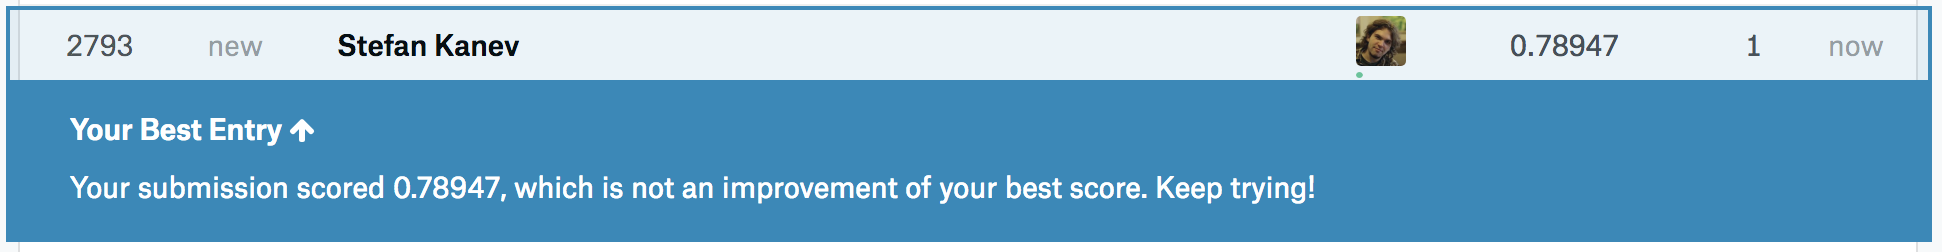

Два въпроса:

* Защо не съм по-нагоре? (2793/8677)
* Защо точността ми е по-малка?

# Въпроси?